# Activity NN
## Tyler Barna

### Contents
1. [Import Modules and Data](#import)
2. [Visualizing Data](#data)  
3. [Analysis](#analysis)    
    3.1 [Linear Regression](#analysis1)    
    3.2 [Mixture Model](#analysis2)

### 1. Import Modules and Data
<a id='import'></a>

In [2]:
import csv
import dis
import inspect
import os
import sys
import time

import arviz as az
import astropy
import astroquery
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import pymc as pm
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from IPython.display import display_html
from IPython.display import Image

from numpy import interp

from pymc import Model, Normal, Gamma, find_MAP

from scipy import integrate
from scipy import linalg as la
from scipy import optimize

from scipy.stats import beta
from scipy.stats import betabinom
from scipy.stats import binom
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import multivariate_normal as mvn
from scipy.stats import nbinom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import t
from scipy.stats import uniform

from sklearn.linear_model import LinearRegression as linreg
from sklearn import preprocessing as preproc

%matplotlib inline
plt.style.use("seaborn-colorblind")
mpl.rcParams.update({"axes.grid" : False})
plt.style.context(("seaborn-colorblind",))

pp = pprint.PrettyPrinter(indent=4)

## set seed for reproducibility
random.seed(5731)

## import data
df = pd.read_csv("Cepheids_DATA_errMVerrP.csv")
display(df.head())
display(df.describe())

MV  MV_err  LogP  LogP_err
0  1.25    0.50  0.17      0.07
1  5.20    0.60  0.05      0.01
2 -1.58    0.15  0.42      0.02
3 -1.93    0.13  0.42      0.07
4 -2.21    0.12  0.69      0.02

MV      MV_err        LogP    LogP_err
count  162.000000  162.000000  162.000000  162.000000
mean    -3.594136    0.098333    0.812222    0.032593
std      1.072114    0.051827    0.287515    0.021857
min     -6.080000    0.080000    0.050000    0.010000
25%     -4.090000    0.090000    0.602500    0.020000
50%     -3.655000    0.090000    0.800000    0.020000
75%     -3.192500    0.100000    0.990000    0.057500
max      5.200000    0.600000    1.620000    0.070000

### 2. Visualizing Data
<a id='data'></a>

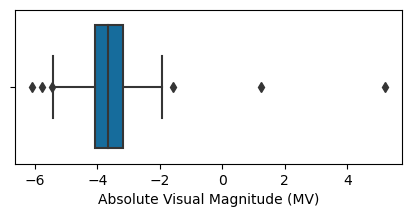

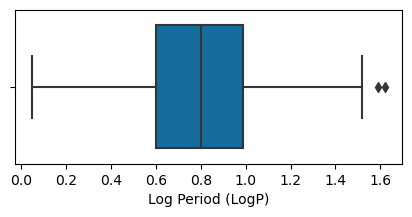

<Figure size 800x800 with 0 Axes>

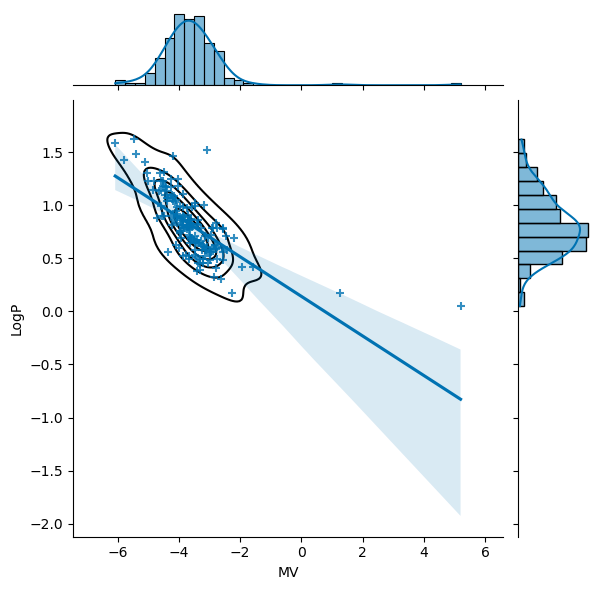

<Figure size 800x800 with 0 Axes>

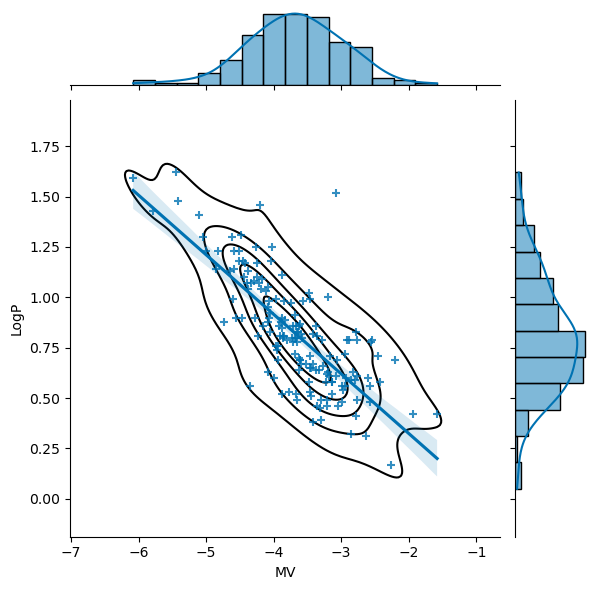

In [5]:
## plot box chart of luminosity
fig, ax = plt.subplots(figsize=(5, 2))
plot = sns.boxplot(data=df, x='MV', ax=ax)
ax.set_xlabel('Absolute Visual Magnitude (MV)')
plt.show()

## plot box chart of dynamical mass
fig, ax = plt.subplots(figsize=(5, 2))
plot = sns.boxplot(data=df, x='LogP', ax=ax)
ax.set_xlabel('Log Period (LogP)')
plt.show()

## plot jointplot of visual magnitude and log period
ax = plt.figure(figsize=(8, 8))
plot = sns.jointplot(data=df, x='MV', y='LogP',
                     kind='reg', marker='+', ax=ax,
                     joint_kws = {'scatter_kws':dict(alpha=0.8)})
plot.plot_joint(sns.kdeplot, zorder=0, levels=6,color='k')
# ax.set_xlabel('X-ray Luminosity')
# ax.set_ylabel('Number of Galaxies')
plt.show()

## plot jointplot of visual magnitude (excluding outliers) and log period
ax = plt.figure(figsize=(8, 8))
plot = sns.jointplot(data=df, x=df[df['MV']<0]['MV'], y='LogP',
                     kind='reg', marker='+', ax=ax,
                     joint_kws = {'scatter_kws':dict(alpha=0.8)})
plot.plot_joint(sns.kdeplot, zorder=0, levels=6,color='k')
# ax.set_xlabel('X-ray Luminosity')
# ax.set_ylabel('Number of Galaxies')
plt.show()

There are a small number of outliers in the absolute visual magnitude. If we exclude these, we can see there is a fairly obvious relation between the log period and the absolute visual magnitude. This suggests that a Bayesian Mixture model may be the best approach to take, but I will first attempt a linear regression model.

### 3. Analysis
<a id='analysis'></a>

#### 3.1 Linear Regression
<a id='analysis1'></a>

This is a similar exercise to a previous week, so I won't go over the steps in much detail prior to the analysis of the results.

In [6]:
x = df['LogP']
x_err = df['LogP_err']
y = df['MV']
y_err = df['MV_err']
basic_model = Model()
with basic_model:
    ## priors for unknown model parameters
    Beta = Normal('beta',mu=0,tau=1./10, shape=2)
    precision = Gamma('precision', alpha=1, beta=1)
    
    mu = Beta[0] + Beta[1]*x
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

In [7]:
map_estimate = find_MAP(model=basic_model)
pp.pprint(map_estimate)


{   'beta': array([-1.49294368, -2.5862834 ]),
    'precision': array(1.65970328),
    'precision_log__': array(0.50663884)}


In [8]:
# Initialize random number generator
RANDOM_SEED = 5731
rng = np.random.default_rng(RANDOM_SEED)

with basic_model:
    start = find_MAP() 

    # draw 1000 posterior samples
    trace = pm.sample( start=start,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [9]:
display(trace)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [10]:
posterior = trace.posterior
display(posterior)

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 1000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (chain, draw, beta_dim_0) float64 -1.311 -2.706 ... -1.582 -2.46
    precision   (chain, draw) float64 1.741 1.605 1.689 ... 1.668 1.551 1.564
Attributes:
    created_at:                 2022-11-30T16:28:20.638225
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.2.2
    sampling_time:              4.634681701660156
    tuning_steps:               1000

##### Posterior Analysis

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   -1.488  0.183  -1.827   -1.142      0.005    0.003    1555.0   
beta[1]   -2.592  0.212  -2.993   -2.205      0.005    0.004    1583.0   
precision  1.661  0.187   1.313    2.003      0.004    0.003    2103.0   

           ess_tail  r_hat      names  
beta[0]      1724.0    1.0  Intercept  
beta[1]      1672.0    1.0       LogP  
precision    1995.0    1.0  Precision

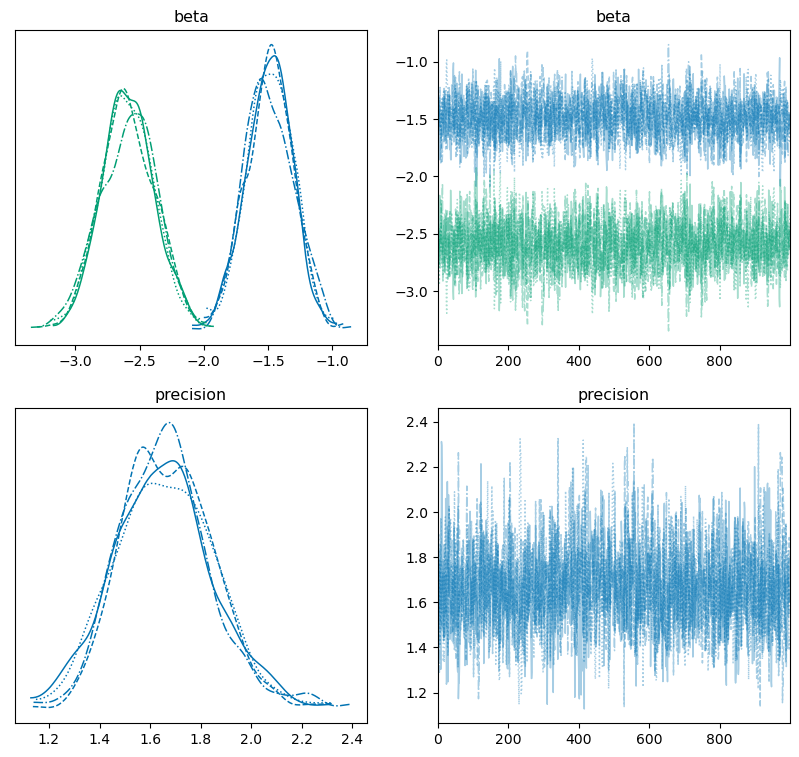

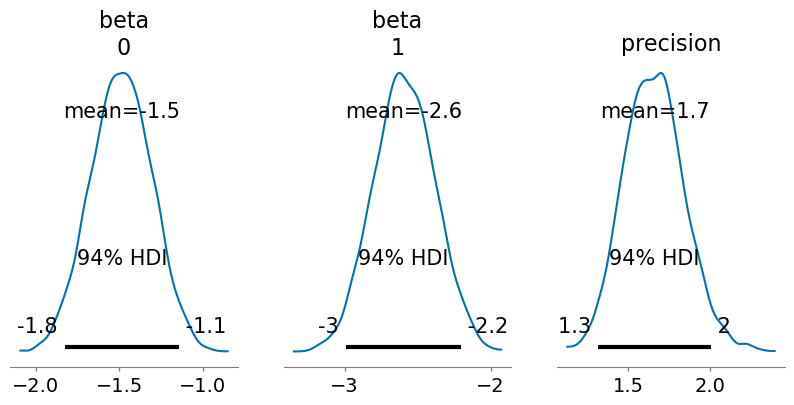

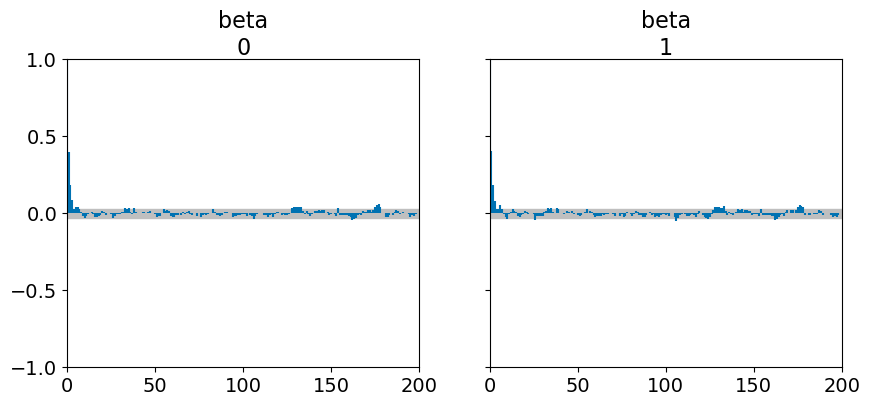

In [17]:
ts = az.summary(trace)
ts['names'] = ['Intercept','LogP','Precision']
display(ts)
az.plot_trace(trace,
              figsize=(10, 9));
plt.show()

az.plot_posterior(trace, figsize=(10, 4));
plt.show();

az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=200,combined=True,figsize=(10, 4))
plt.show();

##### Posterior Predictive Sampling

Sampling: [Y_obs]


<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, Y_obs_dim_0: 162)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * Y_obs_dim_0  (Y_obs_dim_0) int64 0 1 2 3 4 5 6 ... 156 157 158 159 160 161
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_0) float64 -0.3382 -1.014 ... -6.333
Attributes:
    created_at:                 2022-11-30T16:34:52.734507
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.2.2

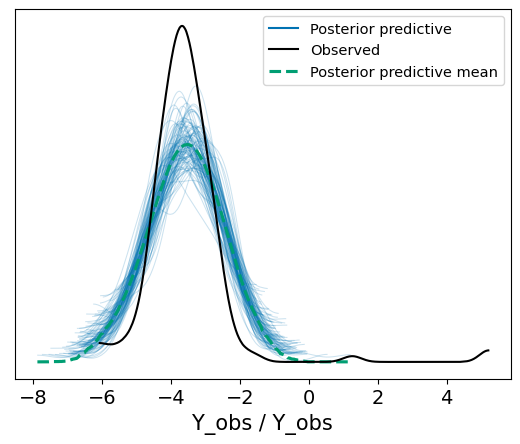

In [19]:
with basic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

display(trace.posterior_predictive)

az.plot_ppc(trace, num_pp_samples=100);
plt.show();

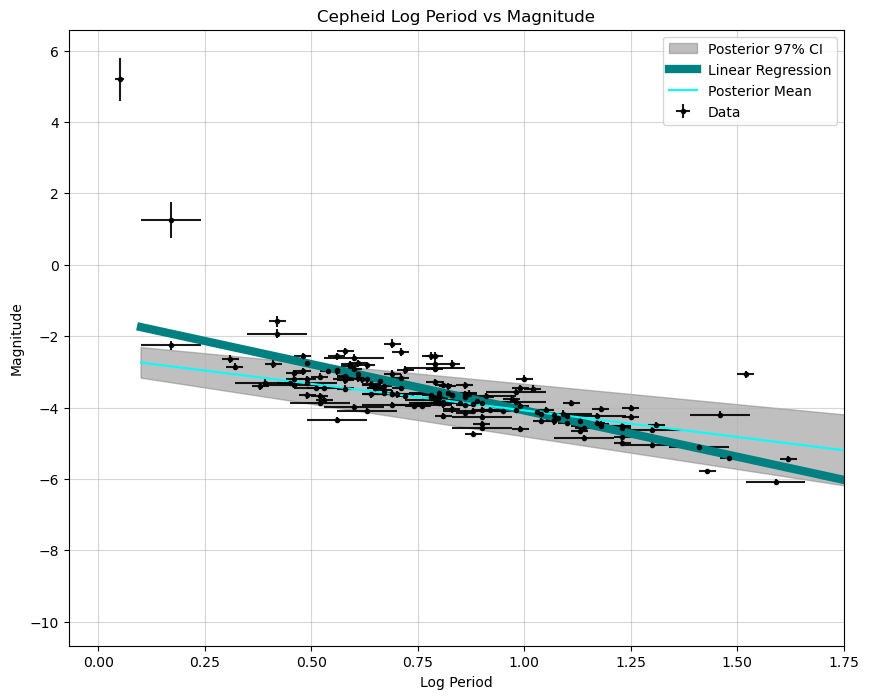

In [21]:
## equation for a line
line = lambda m,x,b: m*x + b

sortedP = np.linspace(df['LogP'].min()*2,df['LogP'].max()*2,1000)
## fit the data with a linear regression with np.polyfit
m, b = np.polyfit(df['LogP'], df['MV'], 1) ## not sorted here
estimated_MV = line(m,sortedP,b)

## estimate fit with posterior 
m_mean = line(ts['mean'][0],sortedP,ts['mean'][1])
m_03 = line(ts['hdi_3%'][0],sortedP,ts['hdi_3%'][1])
m_97 = line(ts['hdi_97%'][0],sortedP,ts['hdi_97%'][1])

## plot the log period vs magnitude with errors for both
fig, ax = plt.subplots(figsize=(10,8), facecolor='white')
ax.errorbar(df['LogP'], df['MV'], xerr=df['LogP_err'], yerr=df['MV_err'], 
            fmt='o', markersize=3, color='black', alpha=0.9, label='Data')

## plot the 97% confidence interval
ax.fill_between(sortedP, m_03, m_97, color='grey', alpha=0.5, label='Posterior 97% CI')

## now plot the estimated magnitude over top of it
ax.plot(sortedP, estimated_MV, 
        lw=6, color='teal', label='Linear Regression')

## plot the mean of the posterior distribution

ax.plot(sortedP, m_mean, color='aqua', label='Posterior Mean')



## styling
# ax.set_xlim(df['LogP'].min()*1.1,df['LogP'].max()*1.1)
ax.set_xlim(-0.07,1.75)
ax.set_xlabel('Log Period')
ax.set_ylabel('Magnitude')
ax.grid(alpha=0.5)
ax.set_title('Cepheid Log Period vs Magnitude')
ax.legend()
plt.show();

Without filtering out the outliers in the magnitude, we can see that the model is thrown off by these values and the posterior predictive sampling is not as accurate. The Bayesian Mixture model should be able to handle this better.

#### 3.2 Bayesian Mixture Model
<a id='analysis2'></a>

In [34]:
x = df['LogP']
x_err = df['LogP_err']
y = df['MV']
y_err = df['MV_err']
mix_model = Model()
with mix_model:
    ## priors for unknown model parameters
    w = pm.Dirichlet('w',a=np.ones(3))
    means = pm.Normal('means1',mu=[0.,1,2],tau=1e-3,shape=(3,))
    Beta = Normal('beta',mu=0,tau=1./10, shape=2)
    tau = pm.Gamma('tau',alpha=0.5, beta=0.5)
    mu = Beta[0] + Beta[1]*x
    #y = pm.Normal('y',mu = means[z], tau = tau,observed=y)
    mu = Beta[0] + Beta[1]*x
    components = [
        pm.Normal.dist(mu=mu, sigma=tau),
        pm.Uniform.dist(lower=-10, upper=10),
    ]

    y_obs = pm.Mixture('y', w=w, comp_dists=components, observed=y)
   
    trace_outl = pm.sample(1000, chains=4, cores=3, init='jitter+adapt_diag',return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


ValueError: Input dimension mismatch. One other input has shape[1] = 3, but input[1].shape[1] = 2.
Apply node that caused the error: Elemwise{Add}[(0, 1)](Elemwise{Log}[(0, 0)].0, Join.0)
Toposort index: 44
Inputs types: [TensorType(float64, (1, None)), TensorType(float64, (None, None))]
Inputs shapes: [(1, 3), (162, 2)]
Inputs strides: [(24, 8), (16, 8)]
Inputs values: [array([[-1.75611035, -2.4987366 , -0.29424239]]), 'not shown']
Outputs clients: [[Max{maximum}{1}(Elemwise{Add}[(0, 1)].0), Elemwise{Composite{Switch(i0, i1, exp((i2 - i3)))}}[(0, 2)](Elemwise{isinf,no_inplace}.0, Elemwise{exp,no_inplace}.0, Elemwise{Add}[(0, 1)].0, InplaceDimShuffle{0,x}.0)]]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.